In [1]:
from pint import *
from sympy import *
from sympy.solvers.solveset import linear_coeffs
import sympy.physics.mechanics as me
import numpy as np

init_printing()

def symb(x, y, z = ''):
    return symbols('{0}_{1}{2}'.format(x, y, z), type = float)

def apply2Eq(fun, eq):
    return Eq(fun(eq.lhs), fun(eq.rhs))


In [9]:
result = pi_theorem({'rho'  : '[mass]/[length]**3',
                     'k'    : '[mass]/[time]**2',
                     'm_n'  : '[length]',
                     't'    : '[time]',
                     'Omega': '1/[time]',
                     'c'    : '[mass]/[time]',
                     'f'    : '[mass]*[length]/[time]**2',
                     'P'    : '[mass]*[length]**2/[time]**3',
                     'sigma': '[mass]/([length]*[time]**2)',
                     'b'    : '[length]',
                     'x'    : '[length]'})

for i in range(len(result)):
    display(formatter(result[i].items()))


#display(result)

'k * t ** 2 / m_n ** 3 / rho'

'Omega ** 2 * m_n ** 3 * rho / k'

'k * m_n ** 3 * rho / c ** 2'

'k * m_n / f'

'P ** 2 * rho / k ** 3 / m_n'

'm_n * sigma / k'

'b / m_n'

'x / m_n'

First, define variables:

In [39]:
X       = IndexedBase('X') # [-], non-dimensional displacement
B       = IndexedBase('B') # [-], non-dimensional face width
tau     = IndexedBase('tau') # [-], non-dimensional time
zeta    = IndexedBase('zeta') # [-], damping ratio
Sigma   = IndexedBase('Sigma') # [-], non-dimensional stress
F       = IndexedBase('F') # [-], non-dimensional force
mu      = IndexedBase('mu') # [-], non-dimensional force from stress
omega   = IndexedBase('omega') # [-], non-dimensional rotation speed
P       = IndexedBase('P') # [kW], power
Omega   = IndexedBase('Omega') # [RPM], rotation speed
sigma   = IndexedBase('sigma') # [Pa], stress
f       = IndexedBase('f') # [N], force
x       = IndexedBase('x') # [mm], displacement
m_n     = IndexedBase('m_n') # [mm], normal module
b       = IndexedBase('b') # [mm], dimensional face width
t       = IndexedBase('t') # [s], time
omega_0 = IndexedBase('omega_0') # [rad/s], normalizing frequency
c       = IndexedBase('c') # [N/m/s], damping
k       = IndexedBase('k') # [N/m], stiffness
m       = IndexedBase('m') # [kg], mass
rho     = IndexedBase('rho') # [kg/m**3], density
V       = IndexedBase('V') # [m**3], volume

Given the following equations:
$$
m \ddot{x} + c \dot{x} + k x = f(t) \\
\sigma_F = C_F \frac{P}{\Omega b d_1 m_n}
$$
The nondimensional groups are given by:

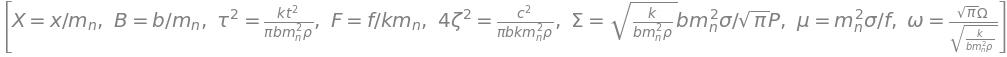

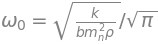

In [40]:
om_rel = Eq(omega_0, sqrt(k/m))
om_rel = om_rel.subs(m, rho*V)
om_rel = om_rel.subs(V, pi*b*m_n**2)

pi1 = Eq(X, x/m_n)

pi2 = Eq(B, b/m_n)

pi3 = Eq(tau**2, (omega_0*t)**2)
pi3 = pi3.subs(om_rel.lhs, om_rel.rhs)

pi4 = Eq(F, f/(k*m_n))

pi5 = Eq(4*zeta**2, c**2/(m*k))
pi5 = pi5.subs(m, rho*V)
pi5 = pi5.subs(V, pi*b*m_n**2)

pi6 = Eq(Sigma, (sigma*omega_0*b*m_n**2)/P)
pi6 = pi6.subs(om_rel.lhs, om_rel.rhs)
pi6 = simplify(pi6)

pi7 = Eq(mu, (sigma*m_n**2)/f)

pi8 = Eq(omega, Omega/omega_0)
pi8 = pi8.subs(om_rel.lhs, om_rel.rhs)

# pi6 = Eq(p, P/(F*m_n*Omega))

PI = [pi1, pi2, pi3, pi4, pi5, pi6, pi7, pi8]

display(PI, om_rel)

Scaling factors:

In [41]:
log_simp = lambda x: expand_log(log(x), force = True)

PI_log = list(map(lambda x: apply2Eq(log_simp,x), PI))

log_PI = list(map(lambda x: x.subs([
                                    (sigma  , 1),   # keep structural safety
                                    (rho    , 1),   # same material
                                    (X      , 1),   # keep non-dimensional displacement (get rid of X and x)
                                    (t      , 1),   # same time scale
                                    (tau    , 1),   # same time scale
                                    (Omega  , 1),   # same frequency range
                                    (omega  , 1),   # same frequency range
                                    (c      , 1),   # keep damping level
                                    (log(pi), 0),   # get rid of this
                                    (log(2) , 0)]), # get rid of this
                                                    PI_log))
# same time scale:
# (tau    , 1), 

for q in log_PI:
    display(q)


In [42]:
def coeff_matrix(equations, *symbols):
    # adapted from the source code of sympy.linear_eq_to_matrix(equations, *symbols)
    A , b = [], []
    for i, f in enumerate(equations):
        coeff_list = linear_coeffs(f, *symbols)
        b.append(-coeff_list.pop())
        A.append(coeff_list)

    A, b = map(Matrix, (A, b))

    return A, b

In [43]:
Gamma = IndexedBase('Gamma')

params = [X, B, tau, zeta, Sigma, F, mu, omega, Omega, sigma, f, x, m_n, b, t, omega_0, c, k, m, rho, P]
PI_gm = log_PI

for elem in params:
    for i, p in enumerate(PI_gm):
        PI_gm[i] = PI_gm[i].subs(log(elem), Gamma[elem])

PI_gm  = list(map(lambda x: x.lhs - x.rhs, PI_gm))
#PI_gm[4] = 2*PI_gm[4]
gm_par = list(map(lambda x: Gamma[x], params))

A, bb = coeff_matrix(PI_gm, *gm_par[:-1]) 

display(A, bb)
for q in PI_gm:
    display(q)

⎡0  0  0  0  0  1    -1    0    0 ⎤
⎢                                 ⎥
⎢0  0  0  0  0  2    1     -1   0 ⎥
⎢                                 ⎥
⎢0  1  0  0  0  1    0     1    -1⎥
⎢                                 ⎥
⎢0  0  2  0  0  2    1     1    0 ⎥
⎢                                 ⎥
⎢0  0  0  1  0  -1  -1/2  -1/2  0 ⎥
⎢                                 ⎥
⎢0  0  0  0  1  -2   0     0    1 ⎥
⎢                                 ⎥
⎣0  0  0  0  0  -1  -1/2  1/2   0 ⎦

⎡    0    ⎤
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎢-Gamma[P]⎥
⎢         ⎥
⎢    0    ⎥
⎢         ⎥
⎣    0    ⎦

In [50]:
x_p = A.pinv()*bb

display(A*x_p - bb)
x_p = x_p.subs(Gamma[P], log(P))

for i, q in enumerate(x_p):
    display(Eq(gm_par[i], q))
    display(Eq(params[i], log_simp(exp(log(q)))))

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

False

False

In [52]:
printing.octave.octave_code(params)

'% Not supported in Octave:\n% IndexedBase\n% IndexedBase\n% IndexedBase\n% IndexedBase\n% IndexedBase\n% IndexedBase\n% IndexedBase\n% IndexedBase\n% IndexedBase\n% IndexedBase\n{B, F, zeta, Sigma, mu, m_n, b, k, f, P}'

In [46]:
get_script = False

if get_script:
    !jupyter nbconvert --to script DA.ipynb

In [47]:
gamma = IndexedBase('gamma')
om_relS = om_rel
om_relR = om_rel
s_idx = symbols('(s)')
r_idx = symbols('(r)')

pars = [X, B, tau, zeta, Sigma, F, mu, omega, P, Omega, sigma, f, x, m_n, b, t, omega_0, c, k, m, rho, V]
PI_s = zeros(len(PI), 1)
PI_r = zeros(len(PI), 1)

for i in range(len(PI)):
    for q in pars:
        PI_s[i] = PI[i].subs(q, q[s_idx])
        PI_r[i] = PI[i].subs(q, q[r_idx])
        om_relS = om_relS.subs(q, q[s_idx])
        om_relR = om_relR.subs(q, q[r_idx])

display(PI_s, om_relS, om_relR)


TypeError: 
The base can only be replaced with a string, Symbol, IndexedBase or an
object with a method for getting items (i.e. an object with a
`__getitem__` method).